In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')

env.call('../002_design_optics/matching_constraints.py')

In [4]:
line = -env['ccs_yl'] + (-env['ccs_xl'])

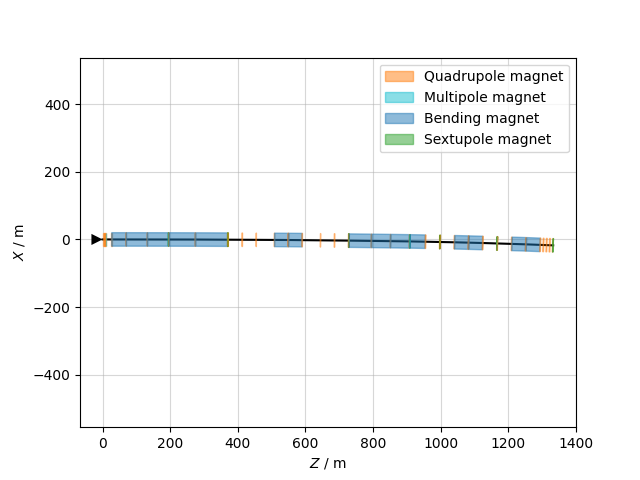

In [5]:
line.survey().plot()

In [6]:
env.vars.load_json('strengths_quads_01_ffccsyl.json')

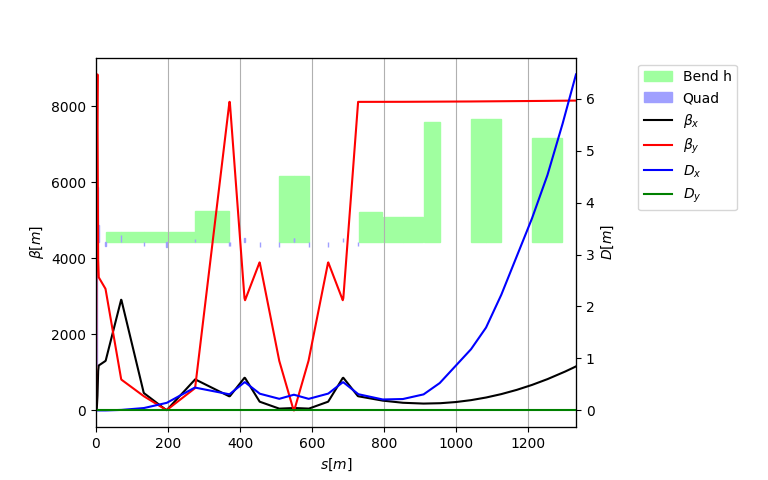

In [7]:
line.twiss(betx=env['bxip'], bety=env['byip']).plot()

In [8]:
kq_section_c = ['kqd07l', 'kqf08l', 'kqd09l', 'kqf10l']
kq_section_d = ['kqd11l', 'kqf12l']
kq_xquads =    ['kqx00l', 'kqx01l', 'kqx02l']
kq_section_e = ['kqf13l', 'kqd14l', 'kqf15l', 'kqd16l',
                   'kqf17l', 'kqd18l', 'kqf19l', 'kqd20l']

In [9]:
# Initialize quadrupoles with a small strength
for nn in kq_section_c + kq_section_d + kq_xquads + kq_section_e:
    if line.vars.vary_default[nn]['limits'][1] > 1e-3: # Focusing quad
        line[nn] = 1e-3
    else: # Defocusing quad
        line[nn] = -1e-3

In [10]:
opt_ipimag3 = line.match(
    name='imag3',
    solve=False,
    betx=env['bxip'], bety=env['byip'],
    default_tol=1e-5,
    vary=xt.VaryList(kq_section_c, step=1e-10),
    targets=[
        xt.TargetSet(betx=xt.LessThan(27.0),
                     bety=xt.LessThan(15.0),
                     alfx=xt.GreaterThan(0.),
                     alfy=xt.GreaterThan(0.5),
                     dx=xt.GreaterThan(0.235),
                     at='sfm2l::0'),
        xt.TargetSet(alfy=xt.LessThan(0.9), dx=xt.LessThan(0.25),
                     at='sfm2l::0')])
opt = opt_ipimag3

In [11]:
opt.step(20)
opt.run_simplex(1000)

                                             
Optimize [imag3] - start penalty: 7856                         
Matching: model call n. 176 penalty = 2.2546e+02              
Optimize [imag3] - end penalty:  225.465                            
                                             
Optimize [imag3] - start penalty: 225.5                         
Matching: model call n. 301 penalty = 0.0000e+00              
Optimize [imag3] - end penalty:     0                            


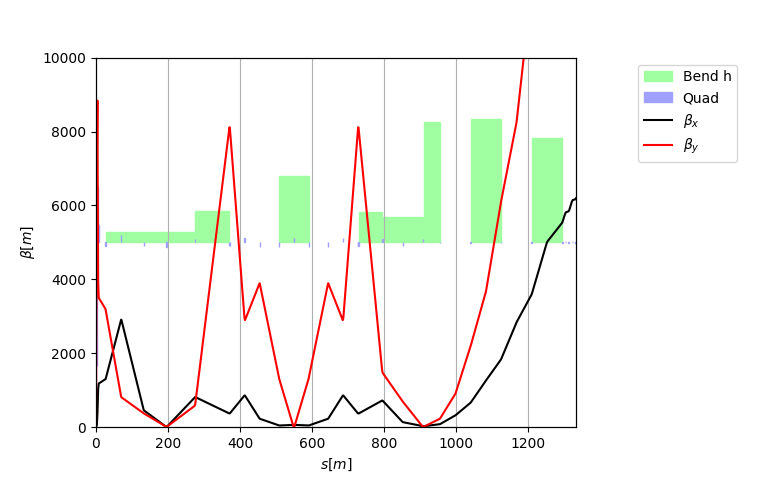

In [12]:
pp=opt.plot('betx bety')
pp.ylim(left_lo=0, left_hi=10000)

In [13]:
opt_sfx1l = opt_ipimag3.clone(name='sfx1l_d',
          remove_vary=True,
          add_vary=xt.VaryList(kq_section_d, step=1e-10),
          add_targets=xt.TargetSet(betx=xt.GreaterThan(1000.),
             alfx=0,
             bety=xt.LessThan(45.),
             dx=xt.LessThan(0.6),
             mux=1.75 - 0.0093,
             at='sfx1l::1'))
opt = opt_sfx1l

In [14]:
opt.step(20)

                                             
Optimize [sfx1l_d] - start penalty: 1096                         
Matching: model call n. 110 penalty = 8.9606e-01              
Optimize [sfx1l_d] - end penalty:  0.896059                            


In [15]:
opt_sfx1l_cd = opt_sfx1l.clone(
    name='sfx1l_cd',
    add_vary=opt_ipimag3.vary)
opt = opt_sfx1l_cd

In [16]:
opt.step(20)

                                             
Optimize [sfx1l_cd] - start penalty: 0.8961                         
Matching: model call n. 54 penalty = 1.0623e-07              
Optimize [sfx1l_cd] - end penalty:  1.06225e-07                            


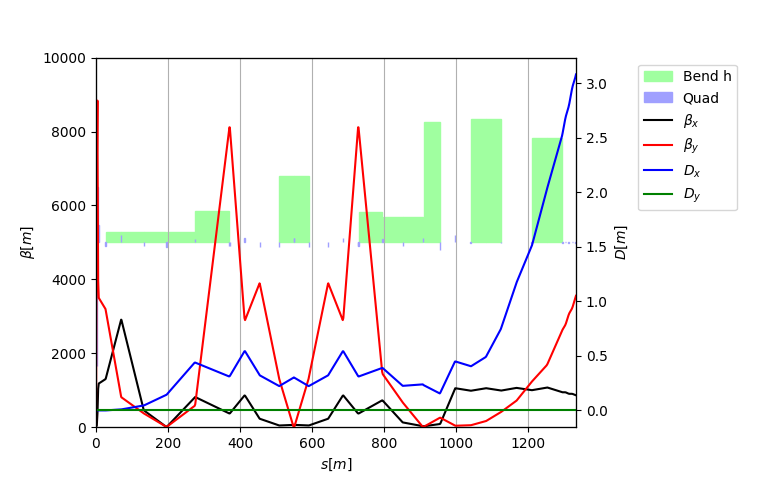

In [17]:
pp=opt.plot()
pp.ylim(left_lo=0, left_hi=10000)

In [18]:
# Match r matrix alone
opt_rsext = line.match(
    name='rmat_sext',
    solve=False,
    default_tol=1e-4,
    start='sfx1l::1', end='sfx2l::1',
    init_at='ipimag4',
    betx=0.20, bety=0.20, # Rough estimate
    targets=xt.TargetRmatrix(start='sfx1l::1', end='sfx2l::1',
                r12=env['r12_ccsxl'], r34=env['r34_ccsxl'],
                r11=-1, r33=-1),
    vary=xt.VaryList(kq_xquads, step=1e-10)
)
opt = opt_rsext
opt.targets['r33'].tol = 1e-3

opt = opt_rsext
opt.disable(target=True)
opt.enable(target=0)
opt.step(20)
opt.enable(target=1)
opt.step(20)
opt.enable(target=2)
opt.step(20)
opt.enable(target=3)
opt.step(20)

                                             
Optimize [rmat_sext] - start penalty: 1.991                         
Matching: model call n. 46 penalty = 1.1873e-05              
Optimize [rmat_sext] - end penalty:  1.1873e-05                            
                                             
Optimize [rmat_sext] - start penalty: 0.1619                         
Matching: model call n. 67 penalty = 3.4842e-06              
Optimize [rmat_sext] - end penalty:  3.48425e-06                            
                                             
Optimize [rmat_sext] - start penalty: 8.106                         
Matching: model call n. 210 penalty = 8.4002e-02              
Optimize [rmat_sext] - end penalty:  0.084002                            
                                             
Optimize [rmat_sext] - start penalty: 53.93                         
Matching: model call n. 348 penalty = 1.2000e-04              
Optimize [rmat_sext] - end penalty:  0.000120005              

In [19]:
opt.target_status()

Target status:               enalty = 1.2000e-04              
id state tag tol_met       residue   current_val    target_val description                                 
0  ON    r11   False     0.0001001       -0.9999            -1 r11(sfx1l::1, sfx2l::1, val=-1, tol=0.00 ...
1  ON    r12    True  -5.06537e-08          -0.1          -0.1 r12(sfx1l::1, sfx2l::1, val=-0.1, tol=0. ...
2  ON    r33    True   6.61901e-05     -0.999934            -1 r33(sfx1l::1, sfx2l::1, val=-1, tol=0.00 ...
3  ON    r34    True  -2.96326e-08  -2.96326e-08             0 r34(sfx1l::1, sfx2l::1, val=0.0, tol=0.0 ...


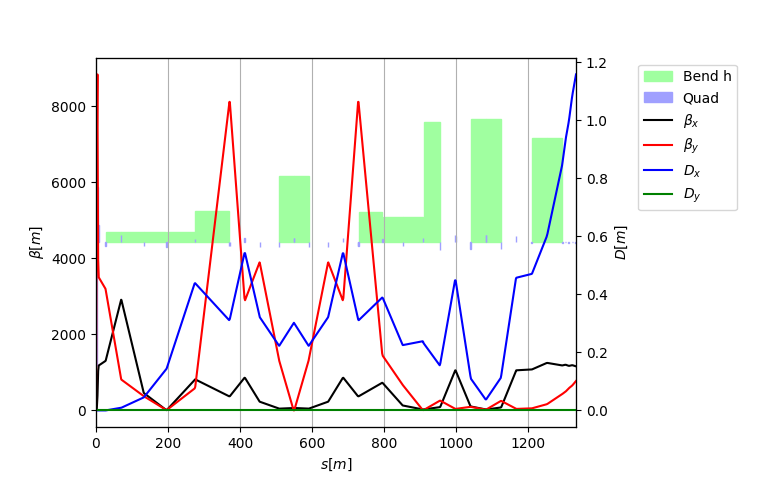

In [20]:
pp = opt_sfx1l_cd.plot()

In [21]:
# Imag 4 without r matrix
opt_imag4 = opt_sfx1l_cd.clone(name='imag4',
                            add_targets=xt.TargetSet(betx=xt.LessThan(20), bety=xt.LessThan(25.),
                                         alfx=0, alfy=env['delta_alfy_ccsx'],
                                         dx=xt.GreaterThan(2e-3),
                                         dpx=env['dpx_ccxl'],
                                         at='ipimag4'))
opt = opt_imag4
opt.step(20)

# Focus on optics at sextupole
opt.disable(target=True)
opt.enable(target='sfx1l.*')
opt.step(200)

                                             
Optimize [imag4] - start penalty: 7.904                         
Matching: model call n. 203 penalty = 3.7615e+00              
Optimize [imag4] - end penalty:  3.76153                            
                                             
Optimize [imag4] - start penalty: 2.914                         
Matching: model call n. 282 penalty = 1.1254e-08              
Optimize [imag4] - end penalty:  1.12536e-08                            


In [22]:
opt_imag4 = opt_sfx1l_cd.clone(name='imag4',
            add_vary=opt_rsext.vary,
            add_targets=list(opt_rsext.targets) + 
                 [xt.TargetSet(betx=xt.LessThan(20), bety=xt.LessThan(25.),
                     alfx=0, alfy=env['delta_alfy_ccsx'],
                     dx=xt.GreaterThan(2e-3),
                     dpx=env['dpx_ccxl'],
                     at='ipimag4')] 
)
opt = opt_imag4

In [23]:
opt.run_jacobian(20)
opt.run_nelder_mead(1000)

                                             
Optimize [imag4] - start penalty: 10.15                         
Matching: model call n. 274 penalty = 1.2035e-02              
Optimize [imag4] - end penalty:  0.0120349                            
                                             
Optimize [imag4] - start penalty: 0.01203                         
Matching: model call n. 1863 penalty = 1.6615e-03              
Optimize [imag4] - end penalty:  0.00166145                            


In [24]:
opt.targets['ipimag4_dx'].weight = 10000
opt.targets['ipimag4_dpx'].weight = 1e6
opt.targets['sfx1l::1_mux'].weight = 10000
opt.run_nelder_mead(1000)

                                             
Optimize [imag4] - start penalty: 1.516                         
Matching: model call n. 3399 penalty = 4.1020e-02              
Optimize [imag4] - end penalty:  0.0410204                            


In [25]:
opt.target_mismatch()

Target mismatch:             penalty = 4.1020e-02              
id state tag           tol_met       residue   current_val target_val         description                                 
4  ON    sfm2l::0_dx     False  -3.49001e-05      0.234965 GreaterThan(0.235) ('dx', 'sfm2l::0'), val=GreaterThan(0.23 ...
9  ON    sfx1l::1_alfx   False   0.000334307   0.000334307 0                  ('alfx', 'sfx1l::1'), val=0, tol=1e-05,  ...
13 ON    r12             False  -0.000718823     -0.100719 -0.1               r12(sfx1l::1, sfx2l::1, val=-0.1, tol=0. ...
15 ON    r34             False    0.00930597    0.00930597 0.0                r34(sfx1l::1, sfx2l::1, val=0.0, tol=0.0 ...
17 ON    ipimag4_bety    False   -0.00423444       25.0042 LessThan(25)       ('bety', 'ipimag4'), val=LessThan(25), t ...
18 ON    ipimag4_alfx    False     0.0031643     0.0031643 0                  ('alfx', 'ipimag4'), val=0, tol=1e-05, w ...
19 ON    ipimag4_alfy    False    0.00221598     -0.197784 -0.2            

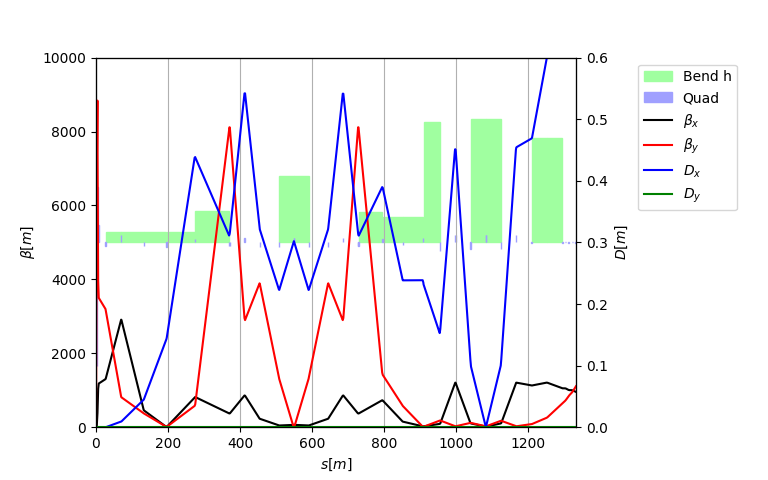

In [26]:
pp=opt.plot()
pp.ylim(left_lo=0, left_hi=10000, right_lo=0, right_hi=.6)

In [27]:
# Try to close with downstream quadrupoles alone
opt_end = opt_imag4.clone(
    name='end',
    remove_vary=True,
    remove_targets=True,
    add_vary=xt.VaryList(kq_section_e, step=1e-10),
    add_targets=[xt.TargetSet(
                       betx=env['bx_ff_out'], alfx=0.0,
                       bety=env['by_ff_out'], alfy = 0.0,
                       dx=env['dx_ff_out'], dpx=0.0,
                       mux=3.0, muy=2.75, at=xt.END),
                 xt.TargetSet(dx=0, dpx=0, at='qf17l'), # to prevent dx going wild in the straight
                 xt.TargetSet(dx=0, dpx=0, at='qd18l'), # to prevent dx going wild in the straight
                 xt.TargetSet(bety=xt.LessThan(2000), at='qf17l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qd18l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qf19l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qd20l'),
                 xt.TargetSet(bety=xt.GreaterThan(750), at='qf19l'),
    ]
)
opt = opt_end

In [28]:
opt.step(10)

                                             
Optimize [end] - start penalty: 1017                         
Matching: model call n. 126 penalty = 6.3246e+02              
Optimize [end] - end penalty:  632.462                            


In [29]:
opt.targets['END_dx'].weight = 100
opt.targets['END_dpx'].weight = 100

In [30]:
opt.step(20)
opt.run_simplex(10000)

                                             
Optimize [end] - start penalty: 632.5                         
Matching: model call n. 387 penalty = 3.3066e+01              
Optimize [end] - end penalty:  33.0661                            
                                             
Optimize [end] - start penalty: 33.07                         
Matching: model call n. 15224 penalty = 8.7068e-01              
Optimize [end] - end penalty:  0.870678                            


In [31]:
opt_full = opt_end.clone(
    name='full',
    add_targets=opt_imag4.targets,
    add_vary=opt_imag4.vary
)
opt=opt_full

In [32]:
# Configure weights
opt.targets['END_mux'].weight = 10000
opt.targets['END_muy'].weight = 10000
opt.targets['END_dpx'].weight = 10000
opt.targets['ipimag4_alfx'].weight = 10000
opt.targets['ipimag4_alfy'].weight = 10000
opt.targets['r33'].weight = 100
opt.targets['r34'].weight = 100

In [33]:
opt.step(50)

                                             
Optimize [full] - start penalty: 869.6                         
Matching: model call n. 341 penalty = 2.1749e-02               
Optimize [full] - end penalty:  0.0217493                            


In [34]:
opt.target_status()


Target status:               enalty = 2.1749e-02              
id state tag           tol_met       residue   current_val target_val         description                                 
0  ON    END_betx         True  -1.64401e-09        66.667 66.667             ('betx', '_end_point'), val=66.667, tol= ...
1  ON    END_bety         True  -6.74384e-08          1600 1600.0             ('bety', '_end_point'), val=1600, tol=1e ...
2  ON    END_alfx         True  -6.14534e-12  -6.14534e-12 0.0                ('alfx', '_end_point'), val=0, tol=1e-05 ...
3  ON    END_alfy         True   7.92833e-10   7.92833e-10 0.0                ('alfy', '_end_point'), val=0, tol=1e-05 ...
4  ON    END_mux          True    4.3876e-13             3 3.0                ('mux', '_end_point'), val=3, tol=1e-05, ...
5  ON    END_muy          True  -1.93179e-13          2.75 2.75               ('muy', '_end_point'), val=2.75, tol=1e- ...
6  ON    END_dx           True  -1.80144e-10  -1.80144e-10 0.0              

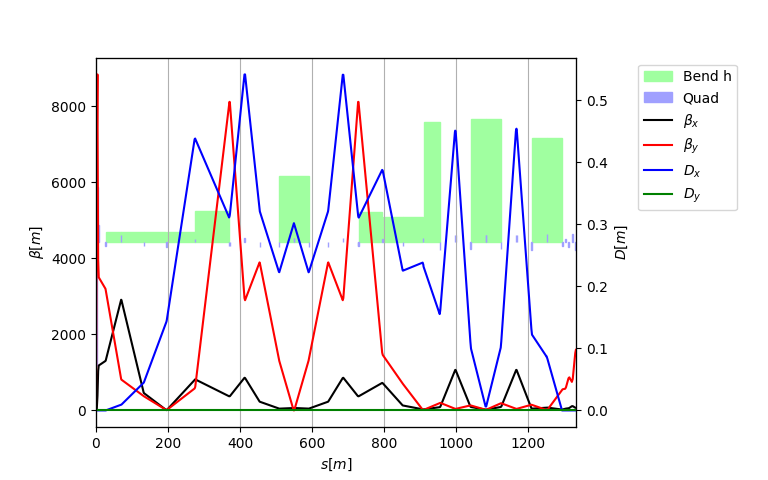

In [35]:
opt.plot()

In [36]:
strengths = opt.get_knob_values()
strengths

{'kqf13l': np.float64(0.023628048419629497),
 'kqd14l': np.float64(-0.0246004549242595),
 'kqf15l': np.float64(0.025603530656983932),
 'kqd16l': np.float64(-0.011824373488500501),
 'kqf17l': np.float64(0.010300270003284883),
 'kqd18l': np.float64(-0.01319411855196473),
 'kqf19l': np.float64(0.02616388811619976),
 'kqd20l': np.float64(-0.022762155119535613),
 'kqd11l': np.float64(-0.024335797614745004),
 'kqf12l': np.float64(0.021491999544704172),
 'kqd07l': np.float64(-0.010836409107848784),
 'kqf08l': np.float64(0.009260717305566303),
 'kqd09l': np.float64(-0.009747439619108),
 'kqf10l': np.float64(0.013857826504616814),
 'kqx00l': np.float64(0.021220279582363322),
 'kqx01l': np.float64(-0.021083201749771678),
 'kqx02l': np.float64(0.02119546033914589)}

In [37]:
xt.json.dump(strengths, 'strengths_quads_02_ffccsxl.json')